In [2]:
import pandas
import plotnine
from plotnine import *

In [3]:
data = pandas.read_csv("10411_games_with_centipawn_metrics.csv")
data = data.drop(
    ["Unnamed: 0", "White Expected Rating by ACPL", "Black Expected Rating by ACPL"],
    axis=1,
)

In [4]:
table = {
    "Title": [
        "Super Grandmaster",
        "Grandmaster",
        "Master",
        "Expert Player",
        "Average Player",
        "Beginner",
    ],
    "ELO": ["2700+", "2500+", "2200-2499", "1800-2199", "1200-1799", "<1200"],
}

table = pandas.DataFrame.from_dict(table)

count = (
    pandas.cut(
        pandas.concat([data["White ELO"], data["Black ELO"]]),
        [0, 1200, 1800, 2200, 2500, 2700, 4000],
        labels=[
            "Beginner",
            "Average Player",
            "Expert Player",
            "Master",
            "Grandmaster",
            "Super Grandmaster",
        ],
    )
    .value_counts()
    .reset_index()
    .rename(columns={"index": "Title", 0: "Number of Games"})
)


pandas.merge(table, count)

,Title,ELO,Number of Games
0,Super Grandmaster,2700+,4661
1,Grandmaster,2500+,8303
2,Master,2200-2499,6348
3,Expert Player,1800-2199,1295
4,Average Player,1200-1799,184
5,Beginner,<1200,31


In [5]:
table = data["Result"].value_counts() / data["Result"].count()
print(table)

1/2-1/2    0.407742
1-0        0.353280
0-1        0.238786
*          0.000192
Name: Result, dtype: float64


In [6]:
data = data[data['Result']!='*']
table = data["Result"].value_counts() / data["Result"].count()
print(table)

1/2-1/2    0.407820
1-0        0.353348
0-1        0.238832
Name: Result, dtype: float64


In [11]:
data[["White Label", "Black Label"]] = data[["White ELO", "Black ELO"]].apply(
    lambda x: pandas.cut(
        x,
        [0, 1200, 1800, 2200, 2500, 2700, 4000],
        labels=[
            "Beginner",
            "Average Player",
            "Expert Player",
            "Master",
            "Grandmaster",
            "Super Grandmaster",
        ],
    ),
    axis=0,
)
data[["White Label", "Black Label", "Result"]]




,White Label,Black Label,Result
0,Master,Expert Player,1-0
1,Master,Grandmaster,1/2-1/2
2,Master,Master,0-1
3,Grandmaster,Master,1-0
4,Master,Master,0-1
...,...,...,...
10405,Grandmaster,Super Grandmaster,1/2-1/2
10406,Grandmaster,Grandmaster,1/2-1/2
10407,Super Grandmaster,Super Grandmaster,1/2-1/2
10409,Grandmaster,Super Grandmaster,1/2-1/2


In [59]:
data.groupby(['White Label','Black Label'])['Result'].value_counts().unstack().fillna(0)

Result                                 0-1    1-0  1/2-1/2
White Label       Black Label                             
Beginner          Beginner             1.0    1.0      0.0
                  Average Player       2.0    0.0      0.0
                  Expert Player        4.0    0.0      0.0
Average Player    Beginner             0.0    2.0      0.0
                  Average Player       1.0    5.0      0.0
                  Expert Player       38.0    7.0      8.0
                  Master              10.0    0.0      1.0
                  Grandmaster          5.0    0.0      0.0
Expert Player     Average Player       2.0   41.0      6.0
                  Expert Player       25.0   56.0     22.0
                  Master             209.0   42.0     75.0
                  Grandmaster        125.0    4.0     13.0
                  Super Grandmaster    4.0    0.0      0.0
Master            Average Player       0.0   22.0      1.0
                  Expert Player       24.0  262.0     54.0
                  Master             411.0  551.0    486.0
                  Grandmaster        594.0  179.0    495.0
                  Super Grandmaster   67.0    6.0     17.0
Grandmaster       Beginner             0.0   16.0      3.0
                  Average Player       0.0   24.0      3.0
                  Expert Player        3.0  142.0     13.0
                  Master             102.0  811.0    398.0
                  Grandmaster        395.0  624.0   1095.0
                  Super Grandmaster  189.0   75.0    292.0
Super Grandmaster Expert Player        0.0   12.0      1.0
                  Master               2.0   70.0     11.0
                  Grandmaster         47.0  298.0    241.0
                  Super Grandmaster  226.0  428.0   1010.0

c:\Users\Vitor Russomano\AppData\Local\Programs\Python\Python310\lib\site-packages\plotnine\layer.py:391: PlotnineWarning: position_stack : Removed 8 rows containing missing values.


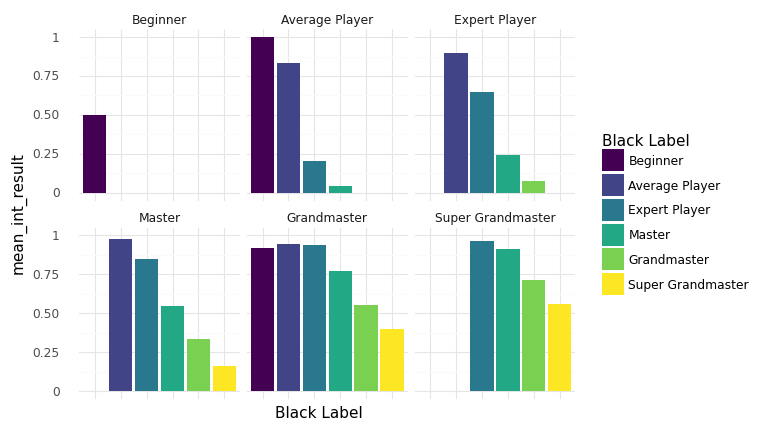

<ggplot: (87469318331)>

In [116]:
data.assign(
    integer_result=lambda _: _.Result.replace({"1-0": 1, "1/2-1/2": 0.5, "0-1": 0})
).groupby(["White Label", "Black Label"]).agg(
    mean_int_result=("integer_result", "mean")
).reset_index().pipe(
    lambda _: ggplot(_, aes(x="Black Label", y="mean_int_result",fill='Black Label'))
    + geom_col()
    + facet_wrap("White Label") 
    + theme_minimal() 
   + theme(axis_text_x=element_blank()))

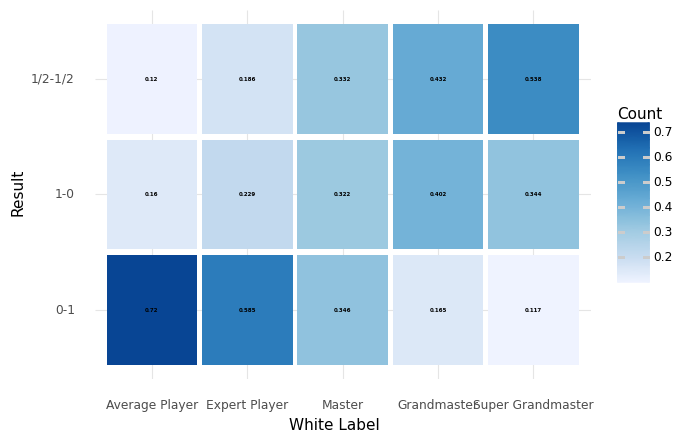

<ggplot: (87468221227)>

In [100]:
data.query('`White Label`!= "Beginner" &  `Black Label` != "Beginner"').groupby(
    ["White Label", "Result"]
).size().fillna(0).unstack().transpose().apply(lambda x: x.div(x.sum(), axis=0)).drop(
    "Beginner", axis=1
).stack().reset_index().rename(
    columns={0: "Count"}
).pipe(
    lambda _: (
        ggplot(round(_,3), aes("White Label", "Result", fill="Count"))
        + geom_tile(aes(width=0.95, height=0.95))
        + scale_fill_distiller(direction=1)
        + geom_text(aes(label="Count"), size=4, fontweight="bold")
        + theme_minimal()
    )
)

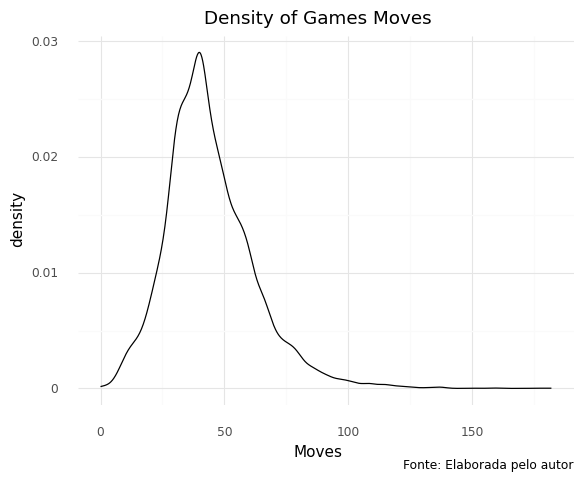

<ggplot: (152308334214)>

In [34]:
(
    ggplot(data, aes(x="Moves"))
    + geom_density(alpha=0.1)
    + theme_minimal()
    + labs(title="Density of Games Moves", caption="Fonte: Elaborada pelo autor") 
)

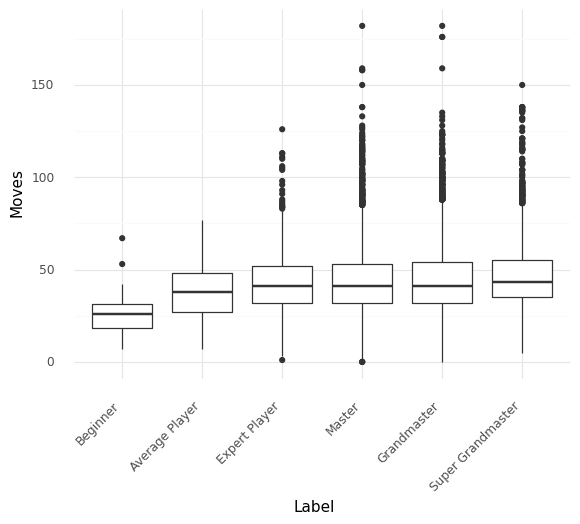

<ggplot: (152294810883)>

In [35]:
(
    ggplot(
        pandas.concat(
            [
                data[["White Label", "Moves"]].rename(columns={"White Label": "Label"}),
                data[["Black Label", "Moves"]].rename(columns={"Black Label": "Label"}),
            ]
        )
    )
    + geom_boxplot(aes(x="Label", y="Moves"))
    + theme_minimal()
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

In [36]:
import numpy
Q1 = numpy.percentile(data['Moves'], 25,
                   method = 'midpoint')
 
Q3 = numpy.percentile(data['Moves'], 75,
                   method = 'midpoint')


Interquartil = Q3 -Q1
upper = numpy.where(data['Moves'] >= (Q3+1.5*Interquartil))


lower = numpy.where(data['Moves'] <= (Q1-1.5*Interquartil))


data.drop(upper[0], inplace = True)
data.drop(lower[0], inplace = True)


In [37]:
from ast import literal_eval

data['White CP Loss List'] = data['White CP Loss List'].apply(literal_eval)
data['Black CP Loss List'] = data['Black CP Loss List'].apply(literal_eval)

data['White CP Loss List'].explode()
data['Black CP Loss List'].explode()

0         1
0        26
0         0
0        12
0        17
         ..
10410     0
10410    19
10410     0
10410    17
10410     1
Name: Black CP Loss List, Length: 428360, dtype: object

C:\Users\Vitor Russomano\AppData\Local\Temp\ipykernel_4816\2292242482.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


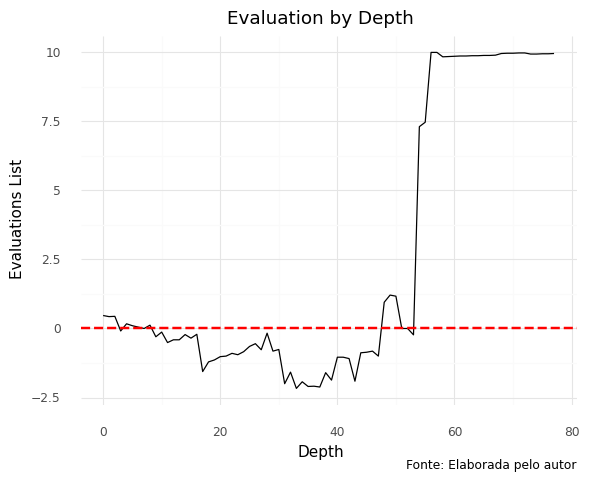

<ggplot: (152310205137)>

In [38]:
teste = pandas.DataFrame()
teste["Evaluations List"] = data["Evaluations List"].apply(literal_eval)

teste = (
    teste.explode("Evaluations List")
    .reset_index()
    .rename(columns={"index": "Game number"})
)
teste["Depth"] = teste.groupby("Game number").cumcount()


k = teste[teste['Game number']==0]
k['Evaluations List'] = pandas.to_numeric(k['Evaluations List'].div(100))



(
    (ggplot(k, aes(x="Depth", y="Evaluations List", group=1)) + geom_line())
    + geom_hline(yintercept=0, linetype="dashed", color="red", size=1)
    + labs(title="Evaluation by Depth", caption="Fonte: Elaborada pelo autor") +
    theme_minimal()
)



c:\Users\Vitor Russomano\AppData\Local\Programs\Python\Python310\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 52 rows containing missing values.


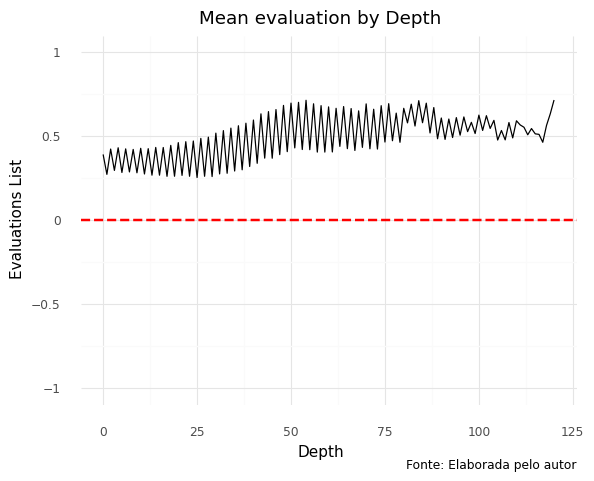

<ggplot: (152294811171)>

In [39]:
a = teste.groupby("Depth")["Evaluations List"].apply("mean").div(100)
a = a.reset_index()

(
    (ggplot(a, aes(x="Depth", y="Evaluations List")) + geom_line())
    + geom_hline(yintercept=0, linetype="dashed", color="red", size=1)
    + theme_minimal()
    + labs(title="Mean evaluation by Depth", caption="Fonte: Elaborada pelo autor")
    + ylim(-1, 1)
    + xlim(0, 120)
)

In [41]:
teste = pandas.DataFrame()
teste["Evaluations List"] = data["Evaluations List"].apply(literal_eval)


teste[["Black Label", "White Label"]] = data[["Black Label", "White Label"]]

teste = (
    teste.explode("Evaluations List")
    .reset_index()
    .rename(columns={"index": "Game number"})
)
teste["Depth"] = teste.groupby("Game number").cumcount()



a = teste.groupby(["Depth", "White Label"])["Evaluations List"].apply("mean").div(100)
a = a.reset_index()


a = a.rename(columns = {'White Label':'WhiteLabel'})


(
    ggplot(a, aes(x="Depth", y="Evaluations List"))
    + geom_area()
    + geom_smooth(method="lm",color="grey",linetype="dotted")
    + facet_wrap('WhiteLabel')
    + geom_hline(yintercept=0, linetype="dashed", color="red", size=1)
    + theme_minimal()
    + labs(title="____", caption="Fonte: Elaborada pelo autor") + xlim(0,120)
)


,Depth,WhiteLabel,Evaluations List
0,0,Beginner,0.408750
1,0,Average Player,0.398961
2,0,Expert Player,0.395008
3,0,Master,0.393409
4,0,Grandmaster,0.392333
...,...,...,...
1033,172,Average Player,NaN
1034,172,Expert Player,NaN
1035,172,Master,-4.745000
1036,172,Grandmaster,-4.946667


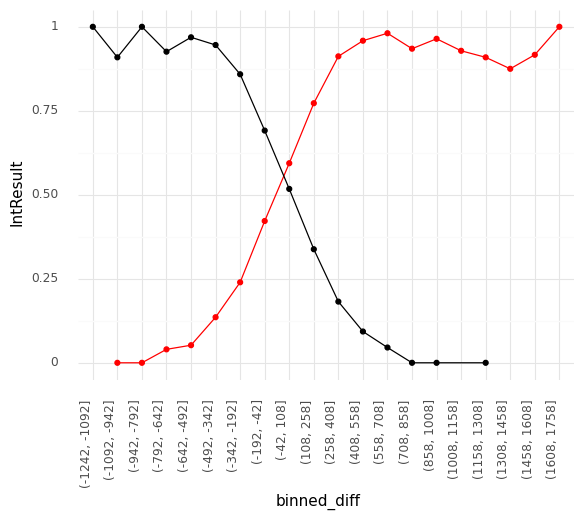

(<ggplot: (155538056544)>,)

In [190]:
import numpy

data["diff"] = data["White ELO"] - data["Black ELO"]
data["2diff"] = data["Black ELO"] - data["White ELO"]
bins = numpy.arange(data["diff"].min(), data["diff"].max(), 150)

data["binned_diff"] = pandas.cut(data["diff"], bins=bins)
data["binned_diff2"] = pandas.cut(data["2diff"], bins=bins)
data["IntResult"] = data["Result"].replace({"1-0": 1, "1/2-1/2": 0.5, "0-1": 0})

res = data.groupby("binned_diff")["IntResult"].apply("mean").dropna().reset_index()
res2 = data.groupby("binned_diff2")["IntResult"].apply("mean").dropna().reset_index()

(
    ggplot()
    + geom_line(res, aes(x="binned_diff", y="IntResult", group=1), color="red")
    + geom_point(res, aes(x="binned_diff", y="IntResult", group=1), color="red")
    + geom_line(res2, aes(x="binned_diff2", y="IntResult", group=1))
    + geom_point(res2, aes(x="binned_diff2", y="IntResult", group=1))
    + theme_minimal()
    + theme(axis_text_x=element_text(rotation=90, hjust=1)),
)

In [269]:
data = pandas.read_csv("10411_games_with_centipawn_metrics.csv")

data['White CP Loss List'] = data['White CP Loss List'].apply(literal_eval)
data['Black CP Loss List'] = data['Black CP Loss List'].apply(literal_eval)

#data['White CP Loss List'].explode().reset_index()
#data['Black CP Loss List'].explode().reset_index()


teste = pandas.DataFrame(columns=['IterCP'], index=  data.index)
from itertools import chain, cycle
import numpy




for i in range(len(data['White CP Loss List'])):
    teste['IterCP'][i] = list(chain(*zip(cycle(data['White CP Loss List'][i]), data['Black CP Loss List'][i])))


teste  = teste['IterCP'].explode().reset_index().rename(columns= {"index" :"Game"})
teste["Depth"] = teste.groupby("Game").cumcount()


white_black = numpy.where(teste['Depth']%2==0, "White", "Black")


teste.groupby(white_black)['IterCP'].agg([numpy.mean, numpy.std, numpy.var,max,min])
# CALCULATE FOR ELO NAME


,mean,std,var,max,min
Black,28.177713,65.073943,4234.618092,2000,0
White,26.952868,62.644783,3924.368845,2000,0


c:\Users\Vitor Russomano\AppData\Local\Programs\Python\Python310\lib\site-packages\plotnine\layer.py:333: PlotnineWarning: stat_density : Removed 304273 rows containing non-finite values.


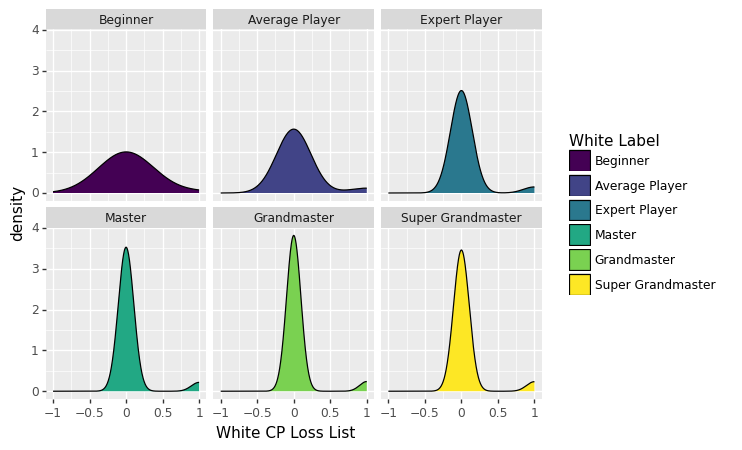

<ggplot: (155561820103)>

In [311]:
data[["White Label", "Black Label"]] = data[["White ELO", "Black ELO"]].apply(
    lambda x: pandas.cut(
        x,
        [0, 1200, 1800, 2200, 2500, 2700, 4000],
        labels=[
            "Beginner",
            "Average Player",
            "Expert Player",
            "Master",
            "Grandmaster",
            "Super Grandmaster",
        ],
    ),
    axis=0,
)

k = data.explode("White CP Loss List")
k["White CP Loss List"] = pandas.to_numeric(k["White CP Loss List"])
k['White CP Loss List'].dropna(inplace=True)
(ggplot(k, aes(x="White CP Loss List", group="White Label",fill="White Label")) + geom_density() + facet_wrap("White Label") + xlim(-1, 1) )

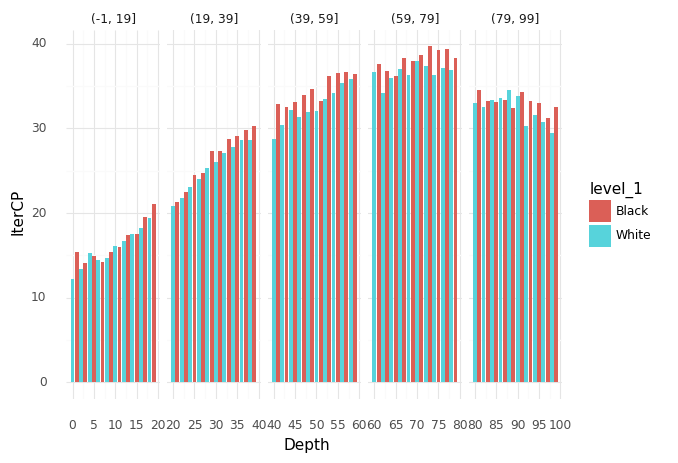

<ggplot: (80565379151)>

In [92]:


new  = teste.groupby(['Depth', white_black])['IterCP'].mean().reset_index()

bins = numpy.arange(-1, 101,20)

new['bins'] = pandas.cut(new['Depth'],bins)
new = new[0:100]

(ggplot(new , aes(x="Depth",y="IterCP",fill="level_1")) + geom_col(stat="identity")  +facet_grid('~bins',scales="free")+ theme_minimal())

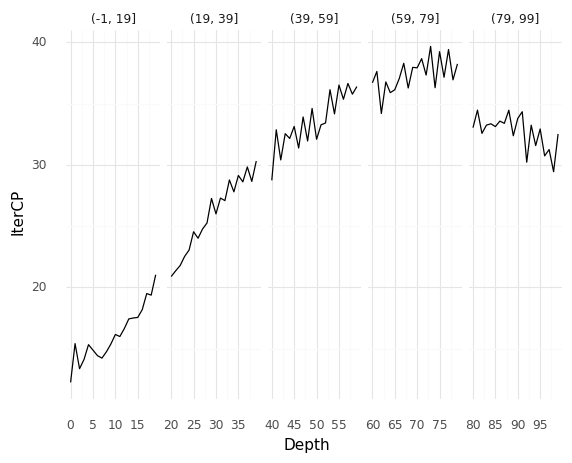

<ggplot: (80570490820)>

In [93]:

new['IterCP'].diff().reset_index().rename(columns={"index":"Depth"})



bins = numpy.arange(-1, 101,20)

new['bins'] = pandas.cut(new['Depth'],bins)
new = new[0:100]

(ggplot(new , aes(x="Depth",y="IterCP")) + geom_line()  +facet_grid('~bins',scales="free")+ theme_minimal())

In [106]:
n = 20
pandas.DataFrame({"Player" :data[['White Name' , 'White ELO']].sort_values(by='White ELO',ascending=False)['White Name'].unique()[0:n],"Ranking (ELO)":numpy.arange(1, n + 1)})

,Player,Ranking (ELO)
0,"Carlsen, Magnus",1
1,"Caruana, Fabiano",2
2,"So, Wesley",3
3,"Mamedyarov, Shakhriyar",4
4,"Vachier Lagrave, Maxime",5
5,"Nakamura, Hikaru",6
6,"Topalov, Veselin",7
7,"Aronian, Levon",8
8,"Ding, Liren",9
9,"Kasparov, Garry",10


In [221]:
DN = ['Carlsen, Magnus', 'Caruana, Fabiano', 'So, Wesley', 'Mamedyarov, Shakhriyar', 'Vachier Lagrave, Maxime','Nakamura, Hikaru', 'Topalov, Veselin', 'Aronian, Levon','Ding, Liren', 'Kasparov, Garry', 'Kramnik, Vladimir','Firouzja, Alireza', 'Anand, Viswanathan', 'Giri, Anish','Grischuk, Alexander', 'Nepomniachtchi, Ian', 'Karjakin, Sergey','Ivanchuk, Vassily', 'Radjabov, Teimour', 'Gelfand, Boris']
data.query(
    f"{DN} in `White Name` or {DN} in `Black Name`"
)

,Unnamed: 0,Date,Event Name,Event Rounds,Round,White Name,Black Name,Result,White ELO,Black ELO,Moves,White Av CP Loss,Black Av CP Loss,Evaluations List,White CP Loss List,Black CP Loss List,PGN,Analysis Depth,White Expected Rating by ACPL,Black Expected Rating by ACPL
386,0,2022-09-02,Sinquefield Cup 9th,9.0,1,"Niemann, Hans Moke","Aronian, Levon",1/2-1/2,2688,2759,50,11.0,11.0,"[44, 25, 50, 36, 44, 35, 35, 35, 37, 35, 46, 8...","[19, 14, 9, 0, 2, 38, 1, 9, 8, 10, 11, 7, 21, ...","[25, 8, 0, 2, 11, 51, 9, 6, 0, 35, 12, 0, 21, ...","[Event ""Sinquefield Cup 9th""]\n[Site ""Saint Lo...",20,NaN,NaN
387,0,2022-09-03,Sinquefield Cup 9th,9.0,2,"Niemann, Hans Moke","Mamedyarov, Shakhriyar",1-0,2688,2757,49,24.0,39.0,"[37, 12, 34, 20, 20, 9, 16, -5, 16, 2, 3, 3, 1...","[25, 14, 11, 21, 14, 0, 0, 41, 18, 20, 15, 12,...","[22, 0, 7, 21, 1, 8, 32, 16, 13, 15, 12, 18, 7...","[Event ""Sinquefield Cup 9th""]\n[Site ""Saint Lo...",20,NaN,NaN
388,0,2022-09-05,Sinquefield Cup 9th,9.0,4,"Niemann, Hans Moke","Firouzja, Alireza",1/2-1/2,2688,2778,43,15.0,15.0,"[37, 33, 44, 23, 41, 25, 32, 23, 26, 14, 17, 1...","[4, 21, 16, 9, 12, 0, 25, 18, 14, 12, 32, 0, 0...","[11, 18, 7, 3, 3, 16, 27, 7, 14, 0, 47, 18, 5,...","[Event ""Sinquefield Cup 9th""]\n[Site ""Saint Lo...",20,NaN,NaN
390,0,2022-09-08,Sinquefield Cup 9th,9.0,6,"Niemann, Hans Moke","So, Wesley",0-1,2688,2771,59,28.0,14.0,"[41, 34, 53, 38, 65, 47, 46, 46, 63, 47, 52, 5...","[7, 15, 18, 0, 16, 0, 0, 9, 13, 5, 23, 8, 17, ...","[19, 27, 0, 17, 5, 0, 0, 0, 20, 18, 13, 21, 20...","[Event ""Sinquefield Cup 9th""]\n[Site ""Saint Lo...",20,NaN,NaN
391,0,2022-09-09,Sinquefield Cup 9th,9.0,7,"Vachier Lagrave, Maxime","Niemann, Hans Moke",1/2-1/2,2757,2688,55,8.0,7.0,"[47, 21, 35, 24, 38, 25, 24, 15, 26, 28, 31, 3...","[26, 11, 13, 9, 0, 0, 0, 4, 22, 13, 0, 12, 14,...","[14, 14, 0, 11, 3, 0, 0, 4, 8, 6, 0, 23, 0, 53...","[Event ""Sinquefield Cup 9th""]\n[Site ""Saint Lo...",20,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10398,0,2022-10-05,U.S. Chess Championship 2022,NaN,01,"Caruana, Fabiano","Dominguez Perez, Leinier",1/2-1/2,2763,2747,48,15.0,15.0,"[49, 41, 33, 35, 36, 28, 39, 35, 39, 16, 22, -...","[8, 0, 8, 4, 23, 32, 1, 0, 14, 12, 1, 28, 22, ...","[0, 1, 11, 4, 6, 10, 1, 0, 10, 16, 1, 0, 21, 1...","[Event ""U.S. Chess Championship 2022""]\n[Site ...",22,2882.0,2882.0
10399,0,2022-10-06,U.S. Chess Championship 2022,NaN,02,"So, Wesley","Yoo, Christopher Woojin",*,2774,2563,49,59.0,38.0,"[49, 41, 33, 35, 48, 40, 40, 59, 44, 37, 46, 3...","[8, 0, 8, 0, 7, 9, 11, 11, 5, 12, 35, 25, 6, 2...","[0, 13, 0, 0, 9, 9, 2, 14, 10, 20, 7, 24, 9, 4...","[Event ""U.S. Chess Championship 2022""]\n[Site ...",22,1588.0,2206.0
10403,0,2022-10-05,U.S. Chess Championship 2022,NaN,01,"Liang, Awonder","So, Wesley",1/2-1/2,2608,2774,34,4.0,3.0,"[49, 41, 33, 35, 36, 12, 12, 13, 17, 19, 26, 2...","[8, 0, 24, 0, 0, 3, 11, 8, 6, 10, 9, 7, 0, 9, ...","[0, 1, 0, 4, 7, 6, 0, 11, 6, 9, 2, 0, 0, 8, 14...","[Event ""U.S. Chess Championship 2022""]\n[Site ...",22,3206.0,3235.0
10405,0,2022-10-05,U.S. Chess Championship 2022,NaN,01,"Lenderman, Aleksandr","Aronian, Levon",1/2-1/2,2535,2755,17,10.0,7.0,"[49, 28, 41, 21, 61, 23, 19, 2, 17, 26, 26, 19...","[21, 20, 38, 17, 0, 7, 17, 21, 0, 28, 0, 0, 0,...","[13, 40, 0, 15, 0, 20, 16, 1, 0, 0, 4, 0, 0, 0...","[Event ""U.S. Chess Championship 2022""]\n[Site ...",22,3029.0,3118.0


In [148]:
cp =pandas.concat(
    [
        pandas.merge(
            data[["White Name"]],
            data["White CP Loss List"]
            .explode()
            .reset_index()
            .rename(columns={"index": "Game"}),
            left_index=True,
            right_on="Game",
        ),
        pandas.merge(
            data[["Black Name"]],
            data["Black CP Loss List"]
            .explode()
            .reset_index()
            .rename(columns={"index": "Game"}),
            left_index=True,
            right_on="Game",
        ),
    ]
)

cp


,White Name,Game,White CP Loss List,Black Name,Black CP Loss List
0,"Niemann, Hans Moke",0,4,NaN,NaN
1,"Niemann, Hans Moke",0,53,NaN,NaN
2,"Niemann, Hans Moke",0,7,NaN,NaN
3,"Niemann, Hans Moke",0,5,NaN,NaN
4,"Niemann, Hans Moke",0,42,NaN,NaN
...,...,...,...,...,...
454699,NaN,10410,NaN,"Xiong, Jeffery",0
454700,NaN,10410,NaN,"Xiong, Jeffery",19
454701,NaN,10410,NaN,"Xiong, Jeffery",0
454702,NaN,10410,NaN,"Xiong, Jeffery",17
